# Sieci konwolucyjne ([CNN](https://bit.ly/3u4eDoR))
### Celem jest wprowadzenie do sieci konwolucyjnych.

Gdy już dowiesz się, co to jest, Twoje życie odmieni się ;)  Za każdym razem, kiedy będziesz chciała / chciał robić jakiekolwiek wartościowe analizy ze zdjęciami, powrócisz do CNN. 

Zaczynamy przygodę!

In [1]:
from scipy import misc
from scipy.signal import convolve2d
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import resize

In [2]:
input_image = imread('../images/norway.jpg')
input_image.shape

/var/folders/00/3f1t2rhd45l6fvmbkz20ptgh00dr78/T/ipykernel_15870/1564866449.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  input_image = imread('../images/norway.jpg')


(1080, 1080, 3)

Uwielbiam podróżować. Jeśli będziesz mieć okazję zwiedzić Norwegię (szczególnie latem), ale obawiasz się tego, bo jest za drogi (i faktycznie taki jest, chociaż da się to zoptymalizować), to mimo wszystko polecam taki wyjazd. Poniżej jeden z widoków, który teraz trochę "pomęczymy".

![](../images/norway.jpg)

Najpierw zmapujmy go do jednego kanału szarości. To trochę ułatwi pracę i zdjęcie będzie wyglądało bardziej naturalnie po następnych transformacjach.

**Uwaga!** Może pojawić się pytanie - skąd wzięły się współczynniki: `[0.299, 0.587, 0.114]`. To jest jedna z możliwych kombinacji konwersji kolorowego zdjęcia w szare (RGB => Grayscale). Więcej o tym można poczytać [tu](https://bit.ly/3eDEXzu) lub [tu](https://bit.ly/2S9S1VM).

(1080, 1080)


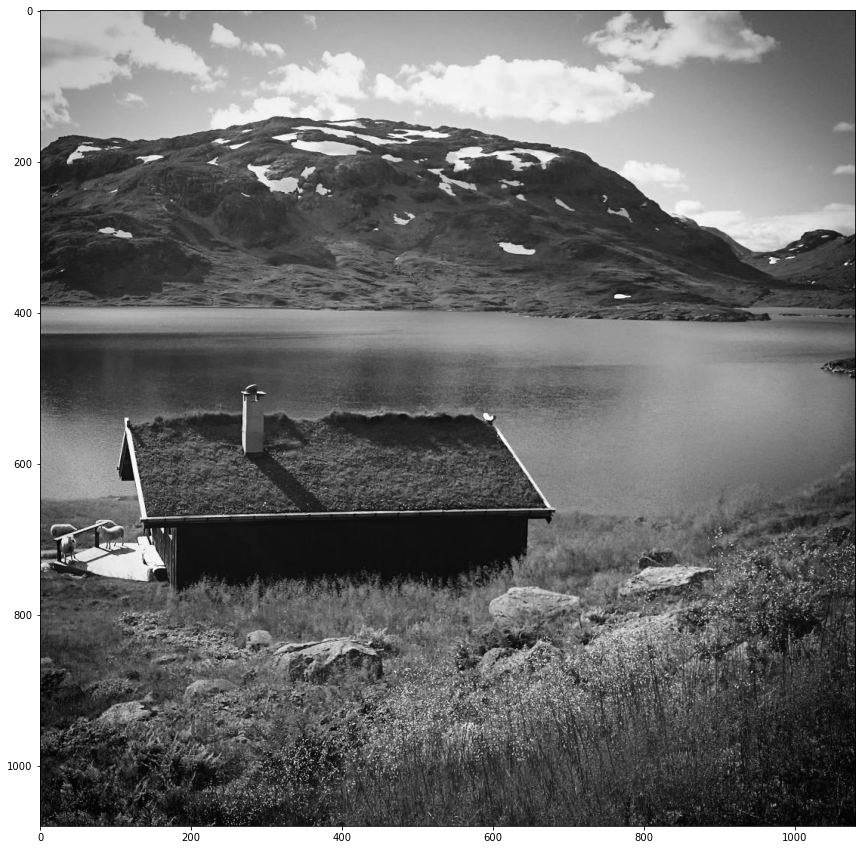

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb, [0.299, 0.587, 0.114])

plt.figure(figsize=(15,15))
gray_image = rgb2gray(input_image)

print(gray_image.shape)
plt.imshow(gray_image, cmap='gray')
plt.show()

Zdjęcie okazało się trochę za duże, wystarczy tylko 40% oryginalnego pliku (dla eksperymentów).

In [4]:
gray_image.shape

(1080, 1080)

(270, 270)


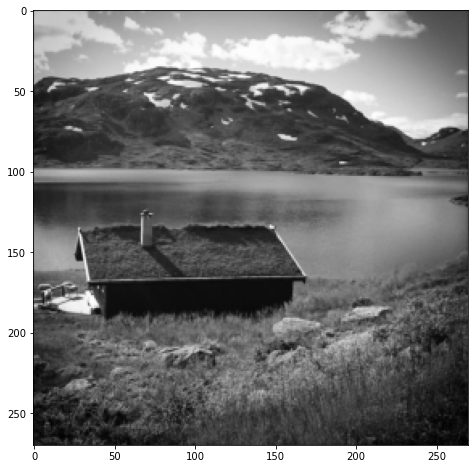

In [5]:
small_image = resize(gray_image, (gray_image.shape[0] / 4, gray_image.shape[1] / 4), mode='constant')
print(small_image.shape)

plt.figure(figsize=(8, 8))
plt.imshow(small_image, cmap='gray')
plt.show()

Poniżej zdefiniujemy funkcję `apply_kernel_to_image`, która będzie nakładać filtr na zdjęcie (nie musisz rozumieć tej funkcji, ona jest pomocna w celach edukacyjnych).

In [6]:
def range_0_255(x):
    if x > 255: return 255
    if x < 0: return 0
    
    return x

def norm(feat):
    vectorize_range_0_255 = np.vectorize(range_0_255)
    return vectorize_range_0_255(np.copy(feat))

def apply_kernel_to_image(img, kernel):

    feature = convolve2d(img, kernel, boundary='symm', mode='same')

    # Plot
    fig = plt.figure(figsize=(15, 6))
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.imshow(img, 'gray')
    ax1.set_title('Input image (512 x 512)', fontsize=15)
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.imshow(kernel, 'gray')
    ax2.set_title('Kernel ({0} x {0})'.format(kernel.shape[0]), fontsize=15)
    ax2.set_xticks([])
    ax2.set_yticks([])

    ax3 = fig.add_subplot(1, 3, 3)
    ax3.imshow(norm(feature), 'gray')
    ax3.set_title('Feature map', fontsize=15)
    ax3.set_xticks([])
    ax3.set_yticks([])
    plt.show()

## Filtry (kernels)
Jest wiele różnych filtrów, dzięki którym można wykrywać krawędź na zdjęciu, wyostrzać je itd. Tutaj jest przykład możliwych filtrów.


![](../images/kernels.png)

### Poniżej animacja pokazująca filtr w działaniu
![](../images/edge_detection.gif)

Zastosujmy teraz kilka filtrów wykrywających brzegi.

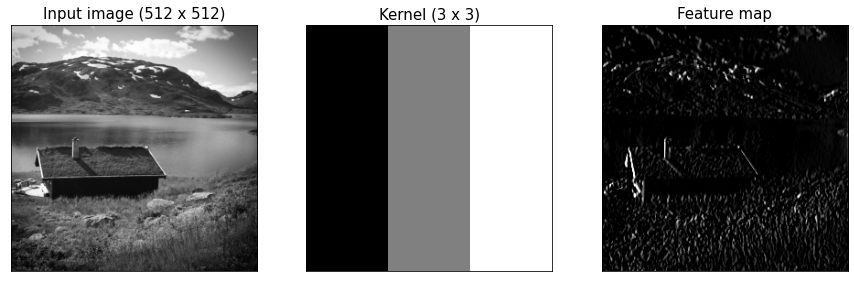

In [7]:
kernel = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]])

apply_kernel_to_image(small_image, kernel)

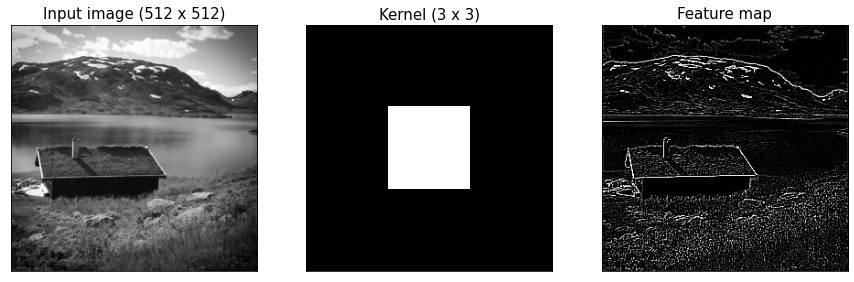

In [8]:
kernel = np.array([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1]])

apply_kernel_to_image(small_image, kernel)

Zobaczmy też, jaki będzie rezultat filtru wyostrzającego.

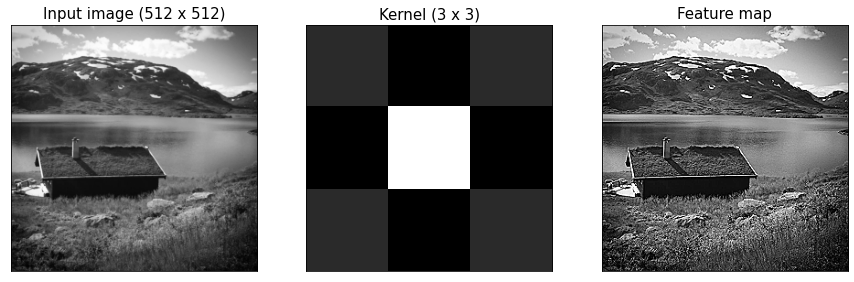

In [9]:
kernel = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]])

apply_kernel_to_image(small_image, kernel)

### Zamazanie obrazu (ang. [*Box Blur*](https://bit.ly/2QMAuTd))

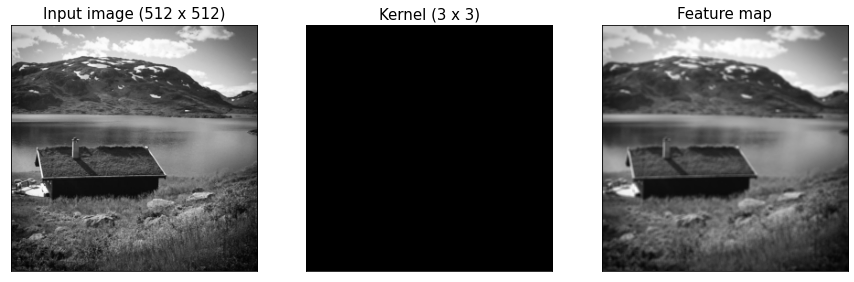

In [10]:
kernel = 1/9 * np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]])

apply_kernel_to_image(small_image, kernel)

## Warstwa konwolucyjna
Dobranie odpowiedniego filtru może być bardzo czasochłonne i przypomina trochę `feature engineering`.

Mam dla Ciebie dobrą wiadomość - nie musisz ręcznie dobierać filtru stosując sieci konwolucyjne. Model sam potrafi to zrobić! Celem trenowania jest właśnie dobór odpowiednich filtrów. To, o czym głównie będziesz decydować to liczba i rozmiar filtrów.

In [11]:
# Tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D

# Keras
#from keras.models import Sequential
#from keras.layers import Conv2D, MaxPool2D

img_rows, img_cols = small_image.shape
my_image = small_image.reshape(img_rows, img_rows, 1)
input_shape = (img_rows, img_cols, 1)

2022-10-22 22:10:01.331663: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Dodajmy jedną warstwę konwolucyjną, która będzie miała 9 filtrów, gdzie każdy będzie miał wymiar 3x3.
Następnie nałożymy te filtry na obraz i zobaczymy rezultat dla każdego z nich.

In [12]:
filters = 9

model = Sequential([
    Conv2D(filters=filters, kernel_size=(3, 3), input_shape=input_shape)
])

model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()
pred = model.predict(np.array([my_image]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 268, 268, 9)       90        
                                                                 
Total params: 90
Trainable params: 90
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 88ms/step


2022-10-22 22:15:25.772968: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Wizualizacja
Zwizualizujmy teraz `Feature maps`, czyli efekt użycia każdego z 9 filtrów.

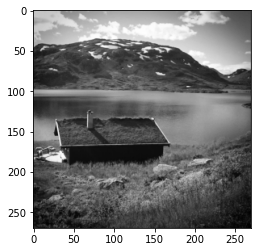

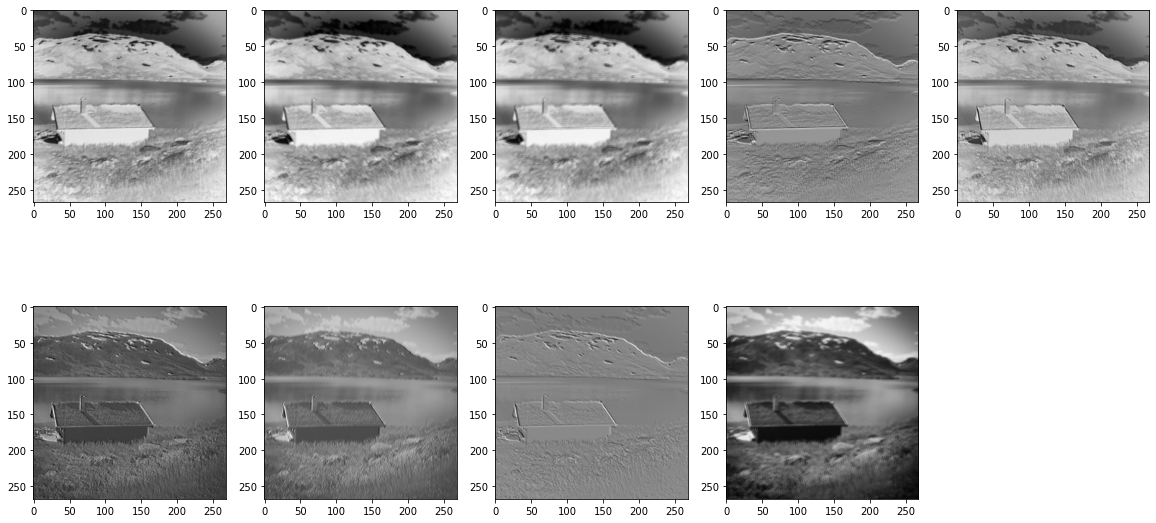

In [16]:
plt.imshow(small_image, cmap='gray')

plt.figure(figsize=(20,10))
for i in range(filters):
    plt.subplot(250 + i + 1)
    plt.imshow(pred[0,:,:,i], cmap='gray')

plt.show()

Teraz oprócz warstwy conv dodamy jeszcze warstwę Pool.

## Conv + Pool

Twoim zadaniem jest zwrócenie uwagi na to, jak zmienia się rozmiar zdjęć (na wyjściu) oraz wizualne odnotowanie, że każdy filtr próbuje wykryć "coś swojego". Warto również zauważyć, że jeśli uruchomisz poniższe 2 komórki po raz kolejny, to wynik będzie trochę inny.

In [17]:
filters = 9

model = Sequential([
    Conv2D(filters=filters, kernel_size=(3, 3), input_shape=input_shape),
    MaxPool2D(pool_size=(2,2))
])

model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()
pred = model.predict(np.array([my_image]))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 268, 268, 9)       90        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 134, 134, 9)      0         
 )                                                               
                                                                 
Total params: 90
Trainable params: 90
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 44ms/step


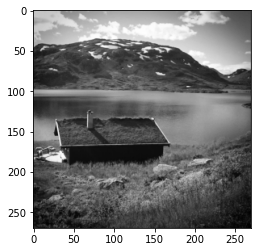

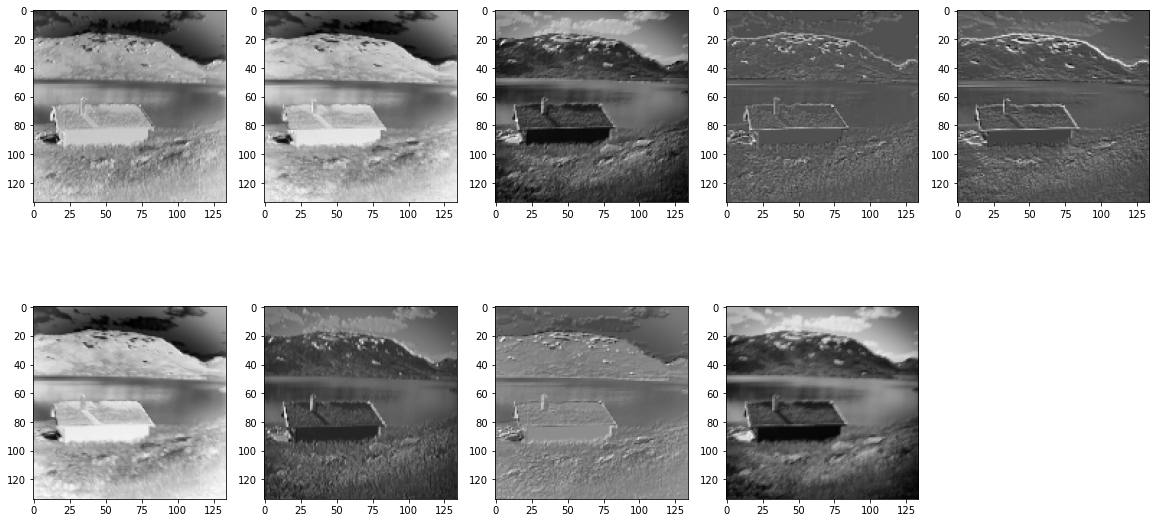

In [19]:
plt.imshow(small_image, cmap='gray')

plt.figure(figsize=(20,10))
for i in range(filters):
    plt.subplot(250+i+1)
    plt.imshow(pred[0,:,:,i], cmap='gray')

plt.show()

## (Conv + Pool) + (Conv + Pool)
Dodajmy teraz kolejne warstwy `Conv + Pool`.

In [20]:
filters = 9

model = Sequential([
    Conv2D(filters=filters, kernel_size=(3, 3), input_shape=input_shape),
    MaxPool2D(pool_size=(2,2)),
    
    Conv2D(filters=filters, kernel_size=(3, 3)),
    MaxPool2D(pool_size=(2,2))
])

model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()
pred = model.predict(np.array([my_image]))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 268, 268, 9)       90        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 134, 134, 9)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 132, 132, 9)       738       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 66, 66, 9)        0         
 2D)                                                             
                                                                 
Total params: 828
Trainable params: 828
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 50ms/step


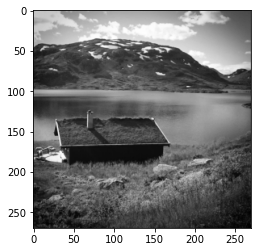

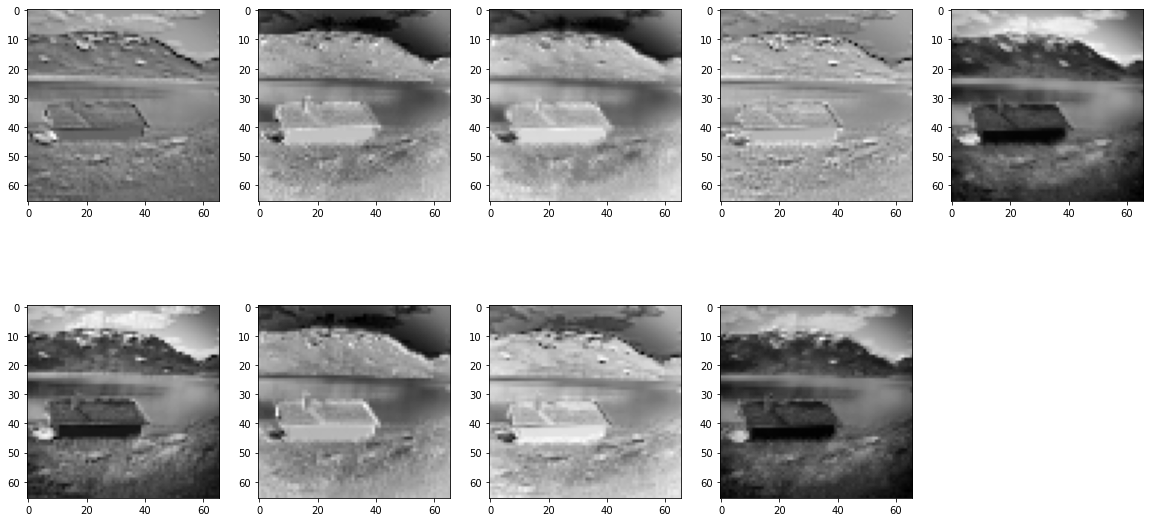

In [22]:
plt.imshow(small_image, cmap='gray')

plt.figure(figsize=(20,10))
for i in range(filters):
    plt.subplot(250+i+1)
    plt.imshow(pred[0,:,:,i], cmap='gray')

plt.show()

Czy widzisz różnicę pomiędzy `(Conv + Pool)` oraz `(Conv + Pool) + (Conv + Pool)`?

Zróbmy teraz 2 razy `Conv + Conv + Pool`.

In [23]:
filters = 9

model = Sequential([
    Conv2D(filters=filters, kernel_size=(3, 3), input_shape=input_shape),
    Conv2D(filters=filters, kernel_size=(3, 3)),
    MaxPool2D(pool_size=(2,2)),
    
    Conv2D(filters=filters, kernel_size=(3, 3)),
    Conv2D(filters=filters, kernel_size=(3, 3)),
    MaxPool2D(pool_size=(2,2)),

])

model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()
pred = model.predict(np.array([my_image]))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 268, 268, 9)       90        
                                                                 
 conv2d_5 (Conv2D)           (None, 266, 266, 9)       738       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 133, 133, 9)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 131, 131, 9)       738       
                                                                 
 conv2d_7 (Conv2D)           (None, 129, 129, 9)       738       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 9)        0         
 2D)                                                  

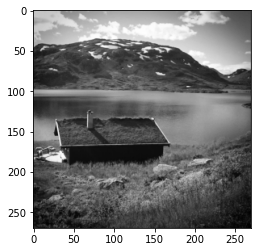

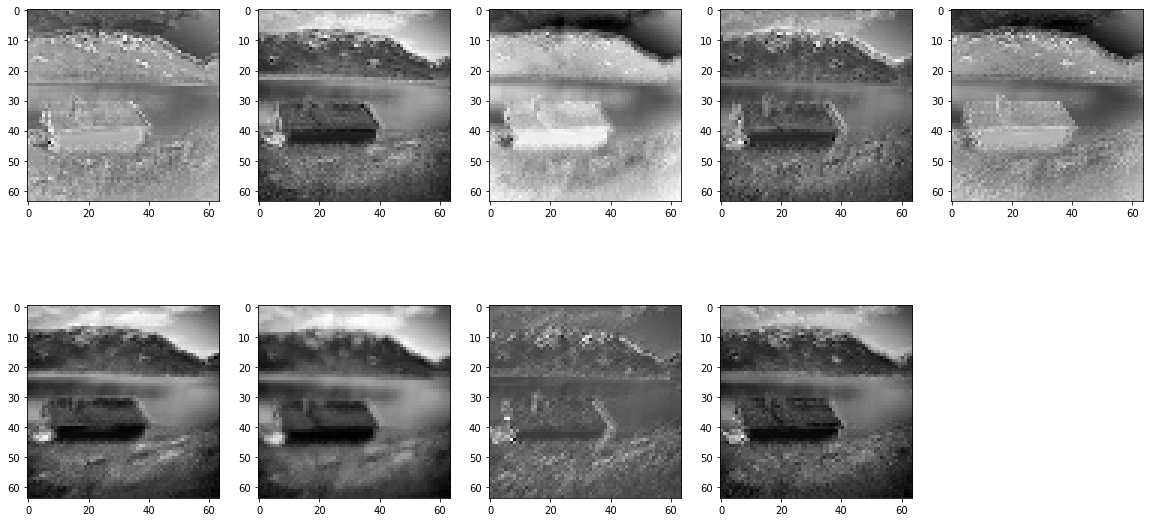

In [24]:
plt.imshow(small_image, cmap='gray')

plt.figure(figsize=(20,10))
for i in range(filters):
    plt.subplot(250+i+1)
    plt.imshow(pred[0,:,:,i], cmap='gray')

plt.show()

## Przydatne linki:
- [Image Filtering](https://bit.ly/3gTCL9Z)
- [Kernel (image processing)](https://bit.ly/3vzB2e1)
- [The Convolution Layer (CNN Visualization)](https://bit.ly/3aTxrja)
- [How do Convolutional Neural Networks work?](https://bit.ly/3udEif0)
- [Understanding Neural Networks Through Deep Visualization](https://bit.ly/2S9ZeFk)
- [Visualizing and Understanding Deep Neural Networks by Matt Zeiler](https://bit.ly/3vz2E2Z)
- [What do computers see?](https://bit.ly/3thUcUp)
- [Rethinking software engineering in the AI era - Yangqing Jia (Facebook)](https://bit.ly/3nBo3FU)
- [A Comprehensive Guide to Convolutional Neural Networks — the ELI5 way](https://bit.ly/3e5CajA)